### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import astropy.convolution as krn
import scipy.stats as stats
import seaborn as sns

from deepeye_analysis_package.plotting import makeHeat

In [2]:
def np_euclidean_distance(y_true, y_pred):
    """
    Compute the Euclidean distance between two sets of points.

    Parameters:
    -----------
    y_true : array-like
        True positions (ground truth).
    y_pred : array-like
        Predicted positions.

    Returns:
    --------
    numpy.ndarray
        Euclidean distances between corresponding points in y_true and y_pred.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true), axis=-1))



### Preprocess files and make dataframe

test_all file contains the results of a validation session. If calibration had to be repeated under the same participant name, then the results of the new validation are appended. Therefore, the test_all file may contain several validation datasets, each with each own header row. 


1. Extract the last dataset from the test_all file based on the header row
2. Label 25-dot dataset based on 9-dot calibration as 25_9, and on 13-dot calibration as 25_13
3. Participants had 3 attempts to get calibration <3 cm. Keep only the successful calibration dataset (total=4)
4. Scale pixels to standard dimensions. Calibration dots were presented as % display size in px
5. Convert pixels to cm
6. Assign each dot a unique label



In [19]:
# # Path to data folders
# path_to_file = 'C:/Users/aby600/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data/2024_02_19_08_03_20/2024_02_19_08_03_20_test_all.csv'


# # Read the entire file into a DataFrame without assuming any header
# df = pd.read_csv(path_to_file, header=None)  # Load without headers

# # Find duplicate rows (potential headers)
# # Assuming headers are duplicated exactly and keep=False to mark all occurrences
# mask_dup = df.duplicated(keep=False)

# # Get the indices of the duplicated rows (which should be headers)
# header_indices = df.index[mask_dup].tolist()

# # Check if we have multiple datasets (i.e., multiple header rows)
# if len(header_indices) > 0:
#     last_header_idx = header_indices[-1]  # Get the index of the last duplicated header

#     # Extract the last dataset starting from the last header row
#     last_dataset = df.iloc[last_header_idx:].reset_index(drop=True)

#     # The row immediately after the last header should be the actual column names
#     last_dataset.columns = last_dataset.iloc[0].values  # Use the first row after the header as column names
#     last_dataset = last_dataset.iloc[1:].reset_index(drop=True)  # Remove the header row and reset index

# else:
#     # If no header is found, assume the entire file is one dataset
#     last_dataset = df  # Treat the entire file as a single dataset
    
#     # Set the first row as column names if no additional headers are found
#     last_dataset.columns = last_dataset.iloc[0].values
#     last_dataset = last_dataset.iloc[1:].reset_index(drop=True)


# # Ensure numeric columns are coerced to the correct type, handle only numeric columns
# numeric_columns = ['numCalibDots', 'x', 'y', 'user_pred_px_x', 'user_pred_px_y', 'scrW_cm', 'resX', 'resY']	
# last_dataset[numeric_columns] = last_dataset[numeric_columns].apply(pd.to_numeric, errors='coerce')

# # Drop rows where 'numCalibDots' is NaN as they are essential for analysis
# last_dataset.dropna(subset=['numCalibDots'], inplace=True)

# # Convert 'numCalibDots' to integer after ensuring no NaN values are present
# last_dataset['numCalibDots'] = last_dataset['numCalibDots'].astype(int)
# last_dataset['eucl_dist_px_orig'] = np_euclidean_distance(np.array(last_dataset[['x','y']]), 
#                                                           np.array(last_dataset[['user_pred_px_x','user_pred_px_y']]))
# last_dataset['scale_cm_in_px'] = last_dataset.scrW_cm/last_dataset.resX
# last_dataset['eucl_dist_cm_orig'] = last_dataset.eucl_dist_px_orig * last_dataset.scale_cm_in_px 

# # Convert coordinates to standard resolution (target_resX and target_resY)
# # Every display resolution is scaled to this one since all dots are drawn in % display size in px
# target_resX = last_dataset.resX.iloc[0] #1280.0
# target_resY = last_dataset.resY.iloc[0] #800.0

# last_dataset['user_pred_px_x_scaled'] = last_dataset.user_pred_px_x/last_dataset.resX * target_resX
# last_dataset['user_pred_px_y_scaled'] = last_dataset.user_pred_px_y/last_dataset.resY * target_resY

# last_dataset['x_scaled'] = np.round(last_dataset.x/last_dataset.resX * target_resX)
# last_dataset['y_scaled'] = np.round(last_dataset.y/last_dataset.resY * target_resY)

# # Get indices of unique dot positions (unique rows)
# u, indices = np.unique(np.array([last_dataset.x_scaled, last_dataset.y_scaled]).T, axis=0, return_inverse=True)
# last_dataset['unique_dot'] = indices



In [3]:
# Path to data folders
path_to_folders = 'C:/Users/aby600/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'
# path_to_folders = 'D:/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'


# get all folder names
folder_names = os.listdir(path_to_folders)

pp_list = []
num_calib_attemtps = []
for fn in folder_names:
    path = os.path.join(path_to_folders, fn, fn+'_test_all.csv')       
        
    try: 
        # Read the entire file into a DataFrame without assuming any header
        df = pd.read_csv(path, header=None)  # Load without headers
        
    except:
        continue



    # Find duplicate rows (potential headers)
    # Assuming headers are duplicated exactly and keep=False to mark all occurrences
    mask_dup = df.duplicated(keep=False)

    # Get the indices of the duplicated rows (which should be headers)
    header_indices = df.index[mask_dup].tolist()

    # Check if we have multiple datasets (i.e., multiple header rows)
    if len(header_indices) > 0:
        last_header_idx = header_indices[-1]  # Get the index of the last duplicated header

        # Extract the last dataset starting from the last header row
        last_dataset = df.iloc[last_header_idx:].reset_index(drop=True)

        # The row immediately after the last header should be the actual column names
        last_dataset.columns = last_dataset.iloc[0].values  # Use the first row after the header as column names
        last_dataset = last_dataset.iloc[1:].reset_index(drop=True)  # Remove the header row and reset index

    else:
        # If no header is found, assume the entire file is one dataset
        last_dataset = df  # Treat the entire file as a single dataset
        
        # Set the first row as column names if no additional headers are found
        last_dataset.columns = last_dataset.iloc[0].values
        last_dataset = last_dataset.iloc[1:].reset_index(drop=True)


    # Ensure numeric columns are coerced to the correct type, handle only numeric columns
    numeric_columns = ['numCalibDots', 'x', 'y', 'user_pred_px_x', 'user_pred_px_y', 'scrW_cm', 'resX', 'resY']	
    last_dataset[numeric_columns] = last_dataset[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows where 'numCalibDots' is NaN as they are essential for analysis
    last_dataset.dropna(subset=['numCalibDots'], inplace=True)

    # Convert 'numCalibDots' to integer after ensuring no NaN values are present
    last_dataset['numCalibDots'] = last_dataset['numCalibDots'].astype(int)
    last_dataset['eucl_dist_px_orig'] = np_euclidean_distance(np.array(last_dataset[['x','y']]), 
                                                            np.array(last_dataset[['user_pred_px_x','user_pred_px_y']]))
    last_dataset['scale_cm_in_px'] = last_dataset.scrW_cm/last_dataset.resX
    last_dataset['eucl_dist_cm_orig'] = last_dataset.eucl_dist_px_orig * last_dataset.scale_cm_in_px 

    # Convert coordinates to standard resolution (target_resX and target_resY)
    # Every display resolution is scaled to this one since all dots are drawn in % display size in px
    target_resX = last_dataset.resX.iloc[0] #1280.0
    target_resY = last_dataset.resY.iloc[0] #800.0

    last_dataset['user_pred_px_x_scaled'] = last_dataset.user_pred_px_x/last_dataset.resX * target_resX
    last_dataset['user_pred_px_y_scaled'] = last_dataset.user_pred_px_y/last_dataset.resY * target_resY

    last_dataset['x_scaled'] = np.round(last_dataset.x/last_dataset.resX * target_resX)
    last_dataset['y_scaled'] = np.round(last_dataset.y/last_dataset.resY * target_resY)

    # Get indices of unique dot positions (unique rows)
    u, indices = np.unique(np.array([last_dataset.x_scaled, last_dataset.y_scaled]).T, axis=0, return_inverse=True)
    last_dataset['unique_dot'] = indices

    last_dataset['subj_nr'] = fn

    # Accumulate datasets across subjects
    pp_list.append(last_dataset)

# Concatenate all subjects in one df
all_df = pd.concat(pp_list)
all_df = all_df.reset_index()




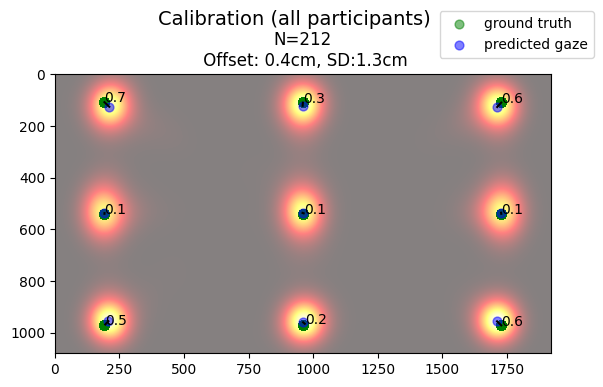

In [4]:
def plot_all_dots(df):
    # Make heatmap of all gaze points of all subjects
    heatmap = makeHeat([target_resX, target_resY], np.array(df.user_pred_px_x_scaled), np.array(df.user_pred_px_y_scaled))    
    
    # Get median gaze prediction per dot
    median_pred_x = df.groupby('unique_dot').user_pred_px_x_scaled.median()
    median_pred_y = df.groupby('unique_dot').user_pred_px_y_scaled.median()  
             
    # Get ground truth per each dot
    true_x = df.groupby('unique_dot').x_scaled.mean()
    true_y = df.groupby('unique_dot').y_scaled.mean()   
        
    # calculate the distance between median gaze prediction to ground truth per each dot
    offset = np_euclidean_distance(np.array([median_pred_x, median_pred_y]).T, np.array([true_x, true_y]).T)    
   
    # Convert to cm
    offset_cm = offset *  df.scale_cm_in_px[0]
    
    # Compute SD   
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled','user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y'] 
    # Add median prediction per dot into the original df
    df = pd.merge(df, median_pred, on="unique_dot", how="left")
    
    # Compute euclidean distance from each gaze sample to median gaze for each dot  
    df['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([df.user_pred_px_x_scaled, df.user_pred_px_y_scaled]).T, 
                                                             np.array([df.median_pred_x, df.median_pred_y]).T)
    
    # Average e.d. for each dot
    SD = df.groupby('unique_dot').eucl_dist_gaze_to_median_px.mean()
    SD_cm = SD * df.scale_cm_in_px[0]
    
    # Get subplot coordinates
    # row = subplot_cell[count_plots2][0]
    # column = subplot_cell[count_plots2][1]
    
    # Plot heatmap for current condition
    plt.figure()

    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha = 0.5, aspect='equal')  
    # Plot true pos and predicted median errors, lines
    plt.scatter(df.x_scaled, df.y_scaled, c='g', s=40, alpha=0.5, label='ground truth')
    plt.scatter(median_pred_x, median_pred_y, c='b', s=40, alpha=0.5, label='predicted gaze')
    plt.plot([median_pred_x, true_x], [median_pred_y, true_y], c='black')
    # Title
    # df['subj_nr'] = 1
    plt.title(f'N={df.subj_nr.unique().size}\n Offset: {np.round(offset_cm.mean(),1)}cm, SD:{np.round(SD_cm.mean(),1)}cm')
    
    # Plot offset values for each dot
    for x,y,e in zip(np.array(true_x), np.array(true_y), np.round(offset_cm, 1)):
        plt.text(x, y, e, fontsize=10)
    
    # count_plots2 += 1      
  
    
    # Save plot
    plt.suptitle(f'Calibration (all participants)', fontsize=14)
    plt.subplots_adjust(top=1.0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.25))
    # fig2.savefig('calibration.jpg', dpi=1000, pad_inches=0)

plot_all_dots(all_df)

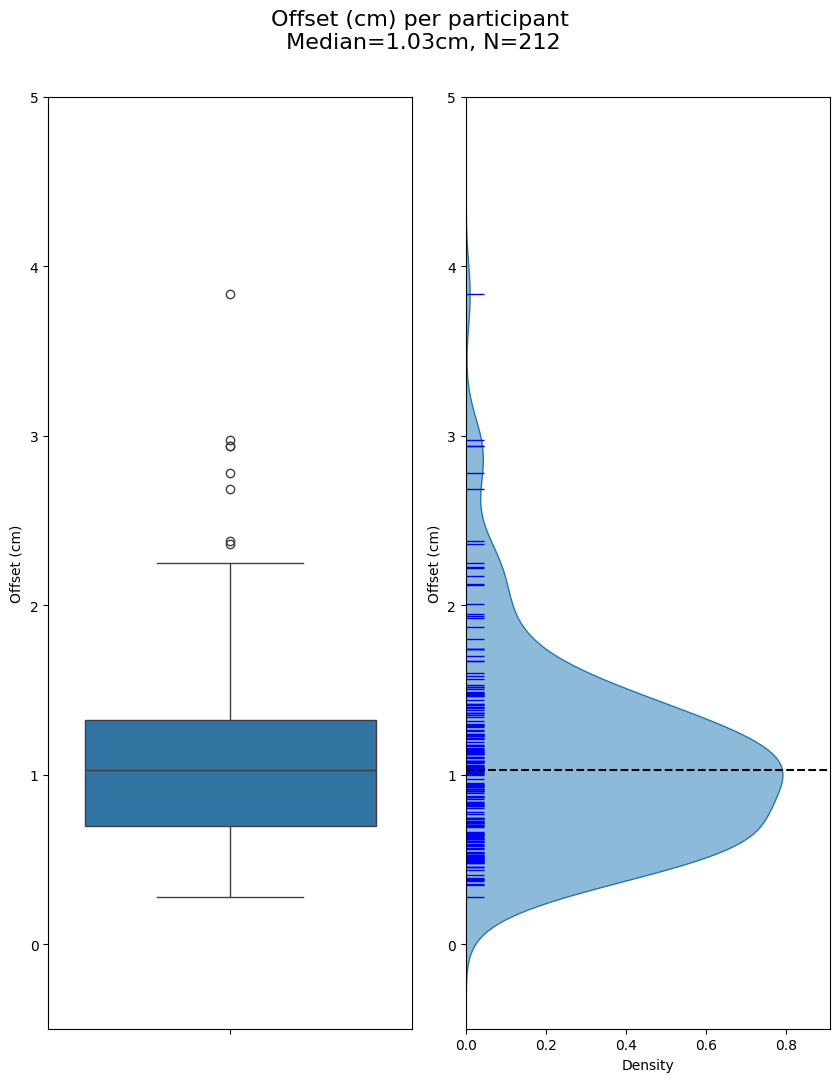

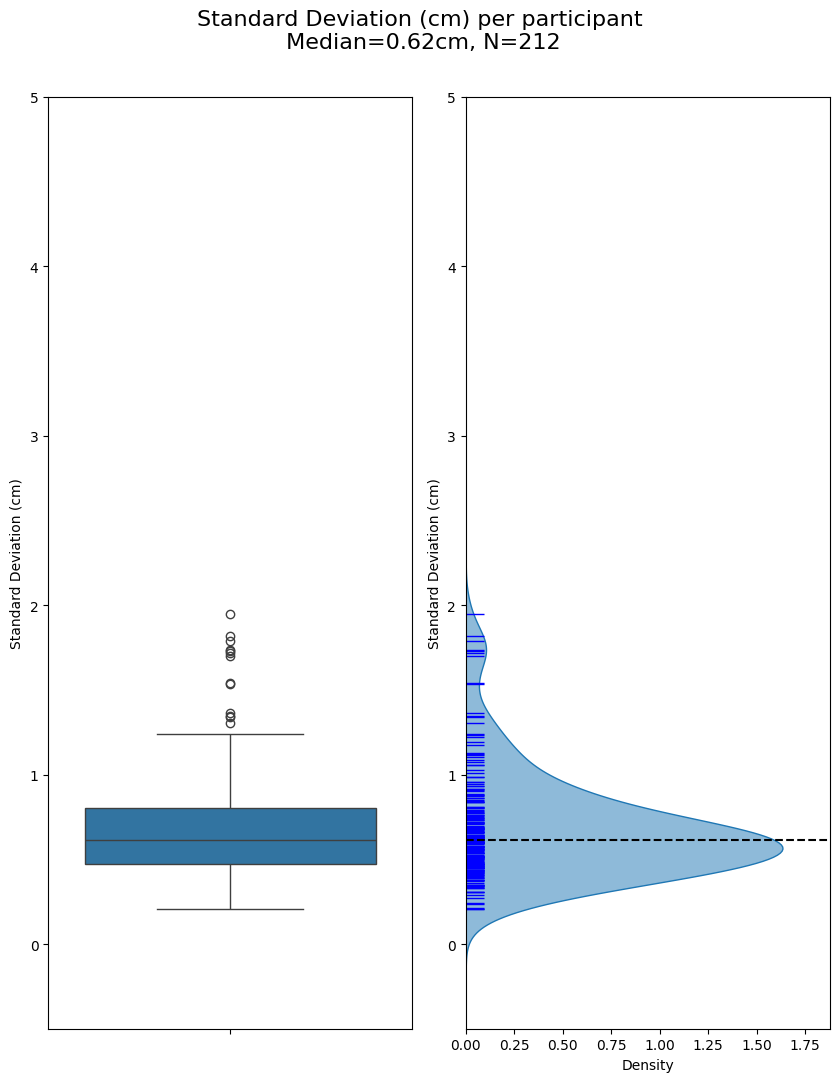

In [8]:
def plot_offset_SD_per_participant(measurement, name=''):

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches((8.5, 11), forward=False)

    sns.kdeplot(y=measurement, ax=ax[1], fill=True, alpha=0.5)
    # Plot individual points
    sns.rugplot(y=measurement, ax=ax[1], height=0.05, color="b")
    median_data = measurement.median()
    plt.axhline(median_data, color='k', linestyle='--', linewidth=1.5, label=f'Median: {median_data:.2f}')
    
    
    sns.boxplot(y=measurement, ax=ax[0])
    
    ax[0].set_ylim(-0.5,5)
    ax[1].set_ylim(-0.5,5)

    # Save plot   
    fig.suptitle(f'{name} per participant\n Median={median_data:.2f}cm, N={all_df.subj_nr.unique().size}', fontsize=16)
    ax[0].set_ylabel(name)
    ax[1].set_ylabel(name)

    fig.tight_layout()    
    fig.subplots_adjust(top=0.9)
    # fig.savefig('summary.jpg', dpi=1000)


# Loop thru each condition
count_plots = 0
summary_df_all = []


    
# df for all subjects for each condition
summary_df = []    

# Loop thru each subject and unique dot
for _, j in all_df.groupby(['subj_nr', 'unique_dot']):
    
    # Get median gaze for each unique dot in pixels
    j['median_pred_x'] = j.user_pred_px_x_scaled.median()
    j['median_pred_y'] = j.user_pred_px_y_scaled.median()
    
    # Get euclidean distance from each gaze sample to median gaze for each dot
    j['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([j.user_pred_px_x_scaled, j.user_pred_px_y_scaled]).T, 
                            np.array([j.median_pred_x, j.median_pred_y]).T)        
    j['eucl_dist_gaze_to_median_cm'] = j.eucl_dist_gaze_to_median_px * all_df.scale_cm_in_px.iloc[0]
    
    # Get euclidean distance from median gaze to ground truth (accuracy)
    j['offset_px'] = np_euclidean_distance(np.array([j.median_pred_x, j.median_pred_y]).T, np.array([j.x_scaled, j.y_scaled]).T)  
    j['offset_cm'] = j.offset_px * all_df.scale_cm_in_px.iloc[0]
    
    summary_df.append(j)        

# Concatenate datasets from all subjects  
summary_df = pd.concat(summary_df)

# Get STD (mean distance of gaze_to_median per subject)
agg_SD = summary_df.groupby(['subj_nr'])[['eucl_dist_gaze_to_median_cm']].mean().reset_index()

# Get offset
agg_OFFSET = summary_df.groupby(['subj_nr'])[['offset_cm']].mean().reset_index()

# Plot offset per subject 
plot_offset_SD_per_participant(agg_OFFSET.offset_cm, name='Offset (cm)')

# Plot SD per subject
plot_offset_SD_per_participant(agg_SD.eucl_dist_gaze_to_median_cm, name='Standard Deviation (cm)')
    


# accumulate all dfs across conditions
summary_df_all.append(summary_df)

# Concatenate datasets across conditions
summary_df_all = pd.concat(summary_df_all)
    



In [12]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['subj_nr', 'pp_id'])['unique_dot'].count().reset_index()
print(f'Descriptive Stats:\n {descr_stats}')

Descriptive Stats:
                  subj_nr    pp_id  unique_dot
0    2024_02_19_08_03_20    28861         400
1    2024_02_19_08_03_44    32041         387
2    2024_02_19_08_04_13    31795         395
3    2024_02_19_08_14_12    29509         395
4    2024_02_19_08_43_42    36313         388
..                   ...      ...         ...
207  2024_03_14_10_26_10    32224         407
208  2024_03_15_08_14_16    36958         404
209  2024_03_15_08_42_43    28672         397
210  2024_03_15_08_53_54    30790         401
211  2024_03_15_11_15_54  31192.0         397

[212 rows x 3 columns]


In [13]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats2 = summary_df_all.groupby(['subj_nr','unique_dot'])['offset_cm'].count().reset_index()
descr_stats3 = descr_stats2.groupby(['subj_nr']).unique_dot.count().reset_index()
print(f'Mean unique dots:\n {descr_stats3}')

Mean unique dots:
                  subj_nr  unique_dot
0    2024_02_19_08_03_20           9
1    2024_02_19_08_03_44           9
2    2024_02_19_08_04_13           9
3    2024_02_19_08_14_12           9
4    2024_02_19_08_43_42           9
..                   ...         ...
207  2024_03_14_10_26_10           9
208  2024_03_15_08_14_16           9
209  2024_03_15_08_42_43           9
210  2024_03_15_08_53_54           9
211  2024_03_15_11_15_54           9

[212 rows x 2 columns]


In [5]:
# Path to data folders
path_to_folders = 'C:/Users/aby600/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'
# path_to_folders = 'D:/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'


# get all folder names
folder_names = os.listdir(path_to_folders)

pp_list = []
num_calib_attemtps = []
for fn in folder_names:
    path = os.path.join(path_to_folders, fn, fn+'_test_all.csv')       
        
    try: 
        # Read CSV file, ensuring that bad rows are handled by ignoring them
        df = pd.read_csv(path)
        
    except:
        continue
    
    
    # Find the headers via duplicates and use it to split into datasets   
    mask_dup = df.duplicated(keep=False)
    # Make indices of datasets
    idx_dup = df.index[mask_dup == True].tolist()
    idx_dup[:0] = [-1] # add lower index
    idx_dup.extend([df.shape[0]]) # add upper index
    
    # Use indices to parse datasets
    df_list = []
    count_datasets = 0
    last_numCalibDots = []
    
    for i in range(len(idx_dup)):
        if i < len(idx_dup) - 1:
            a = df.iloc[idx_dup[i]+1:idx_dup[i+1]]
            a = a.apply(pd.to_numeric, errors='coerce') # when header is written twice, some floats are str, fix this
            a.dropna(subset=['numCalibDots'], inplace=True) # drop rows where numCalibDots = NaN
            a['numCalibDots'] = a['numCalibDots'].astype(int)
            a['dataset_num'] = count_datasets
            

            a['eucl_dist_px_orig'] = np_euclidean_distance(np.array(a[['x','y']]), np.array(a[['user_pred_px_x','user_pred_px_y']]))
            scale_cm_in_px = a.scrW_cm/a.resX
            a['eucl_dist_cm_orig'] = a.eucl_dist_px_orig * scale_cm_in_px 
                                  
           
            a['condition'] = a.numCalibDots.astype(str)
                
            last_numCalibDots.append(a.numCalibDots.iloc[-1]) # log last value                
            
            # Accumulate all dataset per subject
            df_list.append(a)
            count_datasets += 1
    
    
    # if there are more than 4 datasets, remove the recalibrated ones, pick the last one
    last_numCalibDots = pd.Series(last_numCalibDots)
    idx_good_datasets = last_numCalibDots.loc[last_numCalibDots.shift(-1) != last_numCalibDots] # shift dataset by one row and get indices
    df_list = [df_list[i] for i in list(idx_good_datasets.index)] # pick only the 4 datasets
    # assert(len(df_list) == 4)
    
    # Concatenate all datasets per subject
    b = pd.concat(df_list)
    
    # Add a subj_nr column
    b['subj_nr'] = fn    
    
    # Count the number of calibration attempts per participant in a new df
    unique, counts = np.unique(last_numCalibDots, return_counts=True)
    c = pd.DataFrame(np.asarray((unique, counts)).T, columns=['num_calib_dots', 'frequency'])
    c['subj_nr'] = fn
    num_calib_attemtps.append(c)
    num_calib_attempts_df = pd.concat(num_calib_attemtps).reset_index(drop=True)
    
        
    # Accumulate datasets across subjects
    pp_list.append(b)

# Concatenate all subjects in one df
df_all = pd.concat(pp_list)
df_all = df_all.reset_index()


"""
'2023_04_15_11_42_39' - amazing performance, but did not do 25_9
"""
# Exclude subjects
df_all = df_all[df_all.subj_nr != '2023_04_07_13_59_57'] # my pilot data
df_all = df_all[df_all.subj_nr != '2023_04_07_13_45_47'] # my pilot data

# Convert coordinates to standard resolution (target_resX and target_resY)
# Every display resolution is scaled to this one since all dots are drawn in % display size in px
target_resX = df_all.resX.iloc[0] #1280.0
target_resY = df_all.resY.iloc[0] #800.0

df_all['user_pred_px_x_scaled'] = df_all.user_pred_px_x/df_all.resX * target_resX
df_all['user_pred_px_y_scaled'] = df_all.user_pred_px_y/df_all.resY * target_resY

df_all['x_scaled'] = np.round(df_all.x/df_all.resX * target_resX)
df_all['y_scaled'] = np.round(df_all.y/df_all.resY * target_resY)

# Get an average scale for converting to px to cm
df_all['scale_cm_in_px'] = df_all.scrW_cm.astype(float)/df_all.resX.astype(float)
scale_cm_in_px = df_all.scale_cm_in_px.mean() # average scaling factor

# Get indices of unique dot positions (unique rows)
u, indices = np.unique(np.array([df_all.x_scaled, df_all.y_scaled]).T, axis=0, return_inverse=True)
df_all['unique_dot'] = indices

### Plot heatmaps per each condition
Gaze positions for all subjects are combined

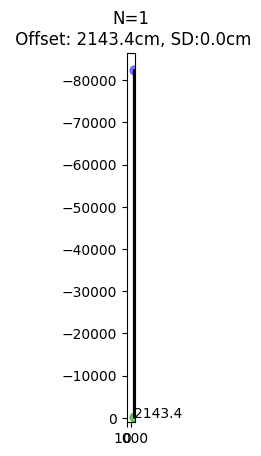

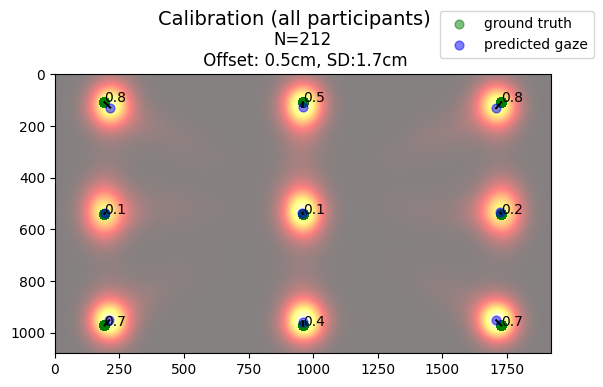

In [6]:

# Iterate per condition
for name, df in df_all.groupby('condition'):

    # Make heatmap of all gaze points of all subjects
    heatmap = makeHeat([target_resX, target_resY], np.array(df.user_pred_px_x_scaled), np.array(df.user_pred_px_y_scaled))    
    
    # Get median gaze prediction per dot
    median_pred_x = df.groupby('unique_dot').user_pred_px_x_scaled.median()
    median_pred_y = df.groupby('unique_dot').user_pred_px_y_scaled.median()  
             
    # Get ground truth per each dot
    true_x = df.groupby('unique_dot').x_scaled.mean()
    true_y = df.groupby('unique_dot').y_scaled.mean()   
        
    # calculate the distance between median gaze prediction to ground truth per each dot
    offset = np_euclidean_distance(np.array([median_pred_x, median_pred_y]).T, np.array([true_x, true_y]).T)    
   
    # Convert to cm
    offset_cm = offset *  scale_cm_in_px
    
    # Compute SD   
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled','user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y'] 
    # Add median prediction per dot into the original df
    df = pd.merge(df, median_pred, on="unique_dot", how="left")
    
    # Compute euclidean distance from each gaze sample to median gaze for each dot  
    df['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([df.user_pred_px_x_scaled, df.user_pred_px_y_scaled]).T, 
                                                             np.array([df.median_pred_x, df.median_pred_y]).T)
    
    # Average e.d. for each dot
    SD = df.groupby('unique_dot').eucl_dist_gaze_to_median_px.mean()
    SD_cm = SD * scale_cm_in_px
    
    # Get subplot coordinates
    # row = subplot_cell[count_plots2][0]
    # column = subplot_cell[count_plots2][1]
    
    # Plot heatmap for current condition
    plt.figure()

    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha = 0.5, aspect='equal')  
    # Plot true pos and predicted median errors, lines
    plt.scatter(df.x_scaled, df.y_scaled, c='g', s=40, alpha=0.5, label='ground truth')
    plt.scatter(median_pred_x, median_pred_y, c='b', s=40, alpha=0.5, label='predicted gaze')
    plt.plot([median_pred_x, true_x], [median_pred_y, true_y], c='black')
    # Title
    plt.title(f'N={df.subj_nr.unique().size}\n Offset: {np.round(offset_cm.mean(),1)}cm, SD:{np.round(SD_cm.mean(),1)}cm')
    
    # Plot offset values for each dot
    for x,y,e in zip(np.array(true_x), np.array(true_y), np.round(offset_cm, 1)):
        plt.text(x, y, e, fontsize=10)
    
    # count_plots2 += 1      
  
    
 # Save plot
plt.suptitle(f'Calibration (all participants)', fontsize=14)
plt.subplots_adjust(top=1.0)
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.25))
# fig2.savefig('calibration.jpg', dpi=1000, pad_inches=0)

### Calculate and plot offsets and SD per condition per subject

1. Offset - euclidean distance from the median gaze prediction per each dot to the ground truth
2. SD - mean of euclidean distances from each gaze prediction to the median gaze prediction for each dot

C:\Users\aby600\AppData\Local\Temp\ipykernel_17432\3422601700.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y=measurement, ax=ax[1], fill=True, alpha=0.5)
C:\Users\aby600\AppData\Local\Temp\ipykernel_17432\3422601700.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y=measurement, ax=ax[1], fill=True, alpha=0.5)


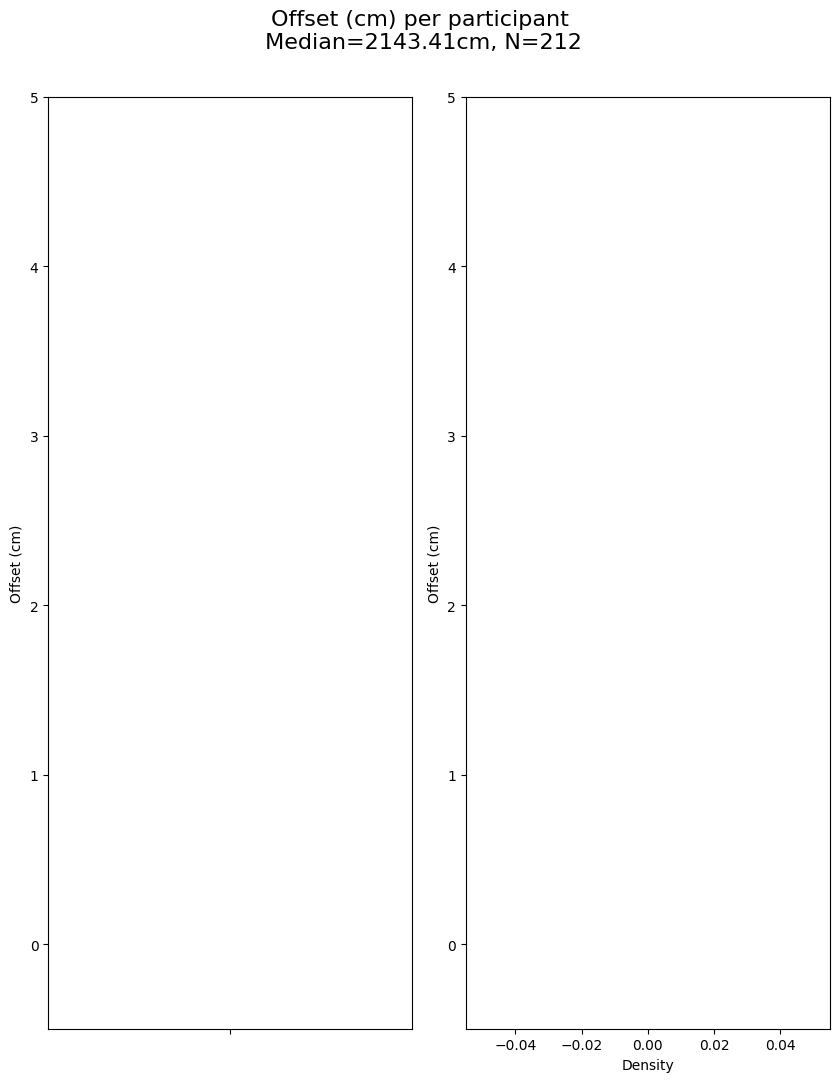

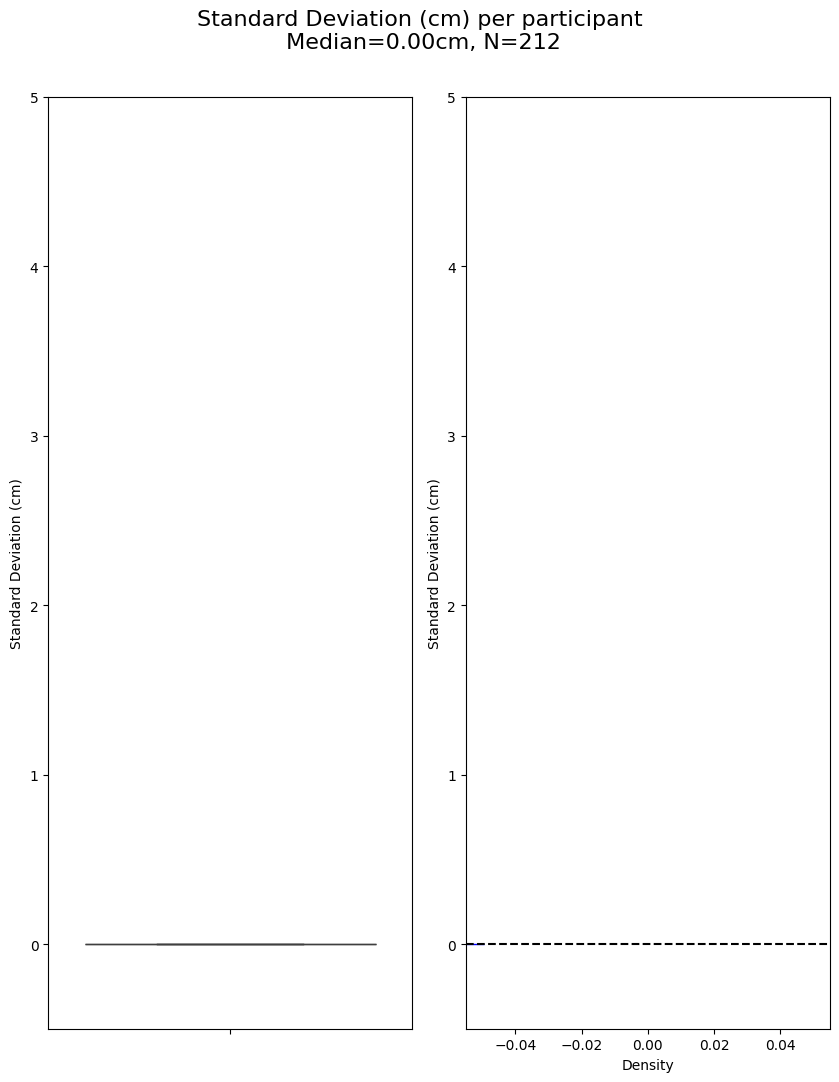

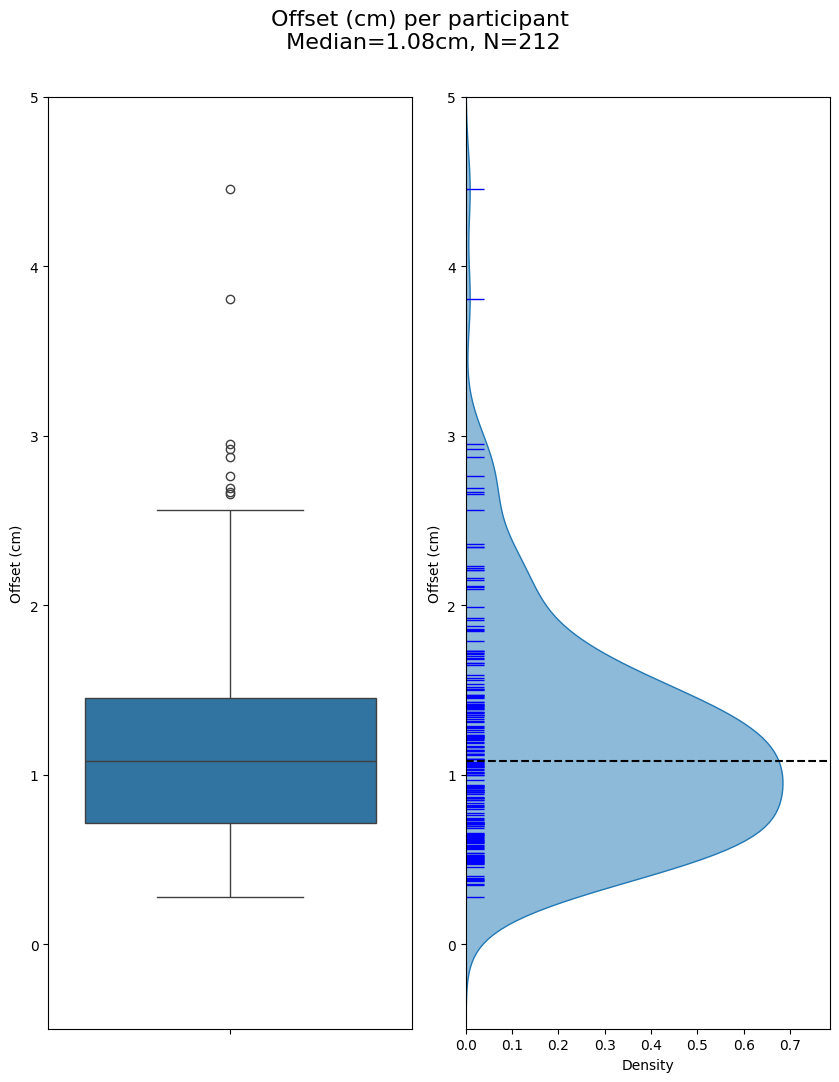

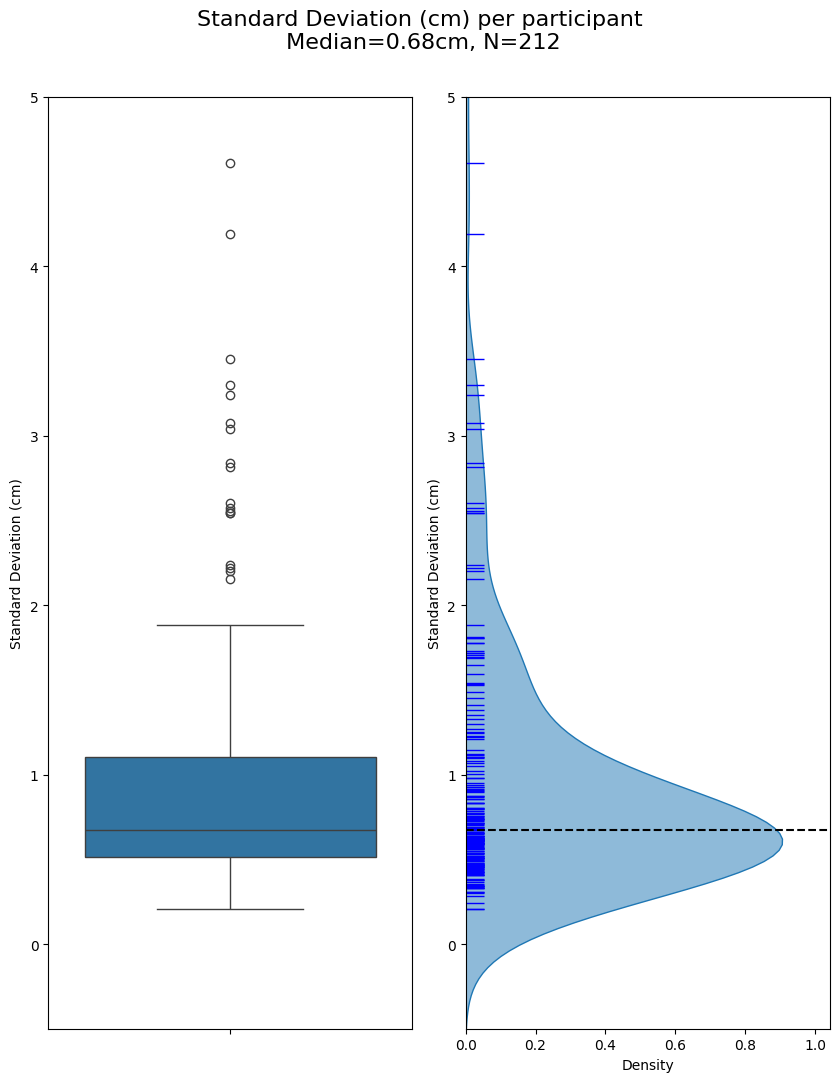

In [7]:
def plot_offset_SD_per_participant(measurement, name=''):

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches((8.5, 11), forward=False)

    sns.kdeplot(y=measurement, ax=ax[1], fill=True, alpha=0.5)
    # Plot individual points
    sns.rugplot(y=measurement, ax=ax[1], height=0.05, color="b")
    median_data = measurement.median()
    plt.axhline(median_data, color='k', linestyle='--', linewidth=1.5, label=f'Median: {median_data:.2f}')
    
    
    sns.boxplot(y=measurement, ax=ax[0])
    
    ax[0].set_ylim(-0.5,5)
    ax[1].set_ylim(-0.5,5)

    # Save plot   
    fig.suptitle(f'{name} per participant\n Median={median_data:.2f}cm, N={df_all.subj_nr.unique().size}', fontsize=16)
    ax[0].set_ylabel(name)
    ax[1].set_ylabel(name)

    fig.tight_layout()    
    fig.subplots_adjust(top=0.9)
    # fig.savefig('summary.jpg', dpi=1000)


# Loop thru each condition
count_plots = 0
summary_df_all = []

for name, i in df_all.groupby('condition'):
    
    # df for all subjects for each condition
    summary_df = []    
   
    # Loop thru each subject and unique dot
    for _, j in i.groupby(['subj_nr', 'unique_dot']):
        
        # Get median gaze for each unique dot in pixels
        j['median_pred_x'] = j.user_pred_px_x_scaled.median()
        j['median_pred_y'] = j.user_pred_px_y_scaled.median()
        
        # Get euclidean distance from each gaze sample to median gaze for each dot
        j['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([j.user_pred_px_x_scaled, j.user_pred_px_y_scaled]).T, 
                              np.array([j.median_pred_x, j.median_pred_y]).T)        
        j['eucl_dist_gaze_to_median_cm'] = j.eucl_dist_gaze_to_median_px * scale_cm_in_px
        
        # Get euclidean distance from median gaze to ground truth (accuracy)
        j['offset_px'] = np_euclidean_distance(np.array([j.median_pred_x, j.median_pred_y]).T, np.array([j.x_scaled, j.y_scaled]).T)  
        j['offset_cm'] = j.offset_px * scale_cm_in_px
        
        summary_df.append(j)        
    
    # Concatenate datasets from all subjects  
    summary_df = pd.concat(summary_df)
    
    # Get STD (mean distance of gaze_to_median per subject)
    agg_SD = summary_df.groupby(['subj_nr'])[['eucl_dist_gaze_to_median_cm']].mean().reset_index()
    
    # Get offset
    agg_OFFSET = summary_df.groupby(['subj_nr'])[['offset_cm']].mean().reset_index()
    
    # Plot offset per subject 
    plot_offset_SD_per_participant(agg_OFFSET.offset_cm, name='Offset (cm)')

    # Plot SD per subject
    plot_offset_SD_per_participant(agg_SD.eucl_dist_gaze_to_median_cm, name='Standard Deviation (cm)')
      
   
    count_plots += 1
    
    # accumulate all dfs across conditions
    summary_df_all.append(summary_df)

# Concatenate datasets across conditions
summary_df_all = pd.concat(summary_df_all)
    



### Overview of participants and the number of included gaze samples

In [ ]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['subj_nr', 'pp_id'])['unique_dot'].count().reset_index()
print(f'Descriptive Stats:\n {descr_stats}')

### Average number of unique dots per condition

In [ ]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['condition','subj_nr','unique_dot'])['offset_cm'].count().reset_index()
descr_stats2 = descr_stats.groupby(['condition', 'subj_nr']).unique_dot.count().reset_index()
descr_stats2 = descr_stats2.groupby('condition').unique_dot.mean()
print(f'Mean unique dots:\n {descr_stats2}')

### How many calibration attempts for 9 and 13 conditions?

In [ ]:
num_calib_attempts_df.groupby('num_calib_dots').frequency.mean()